In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
import seaborn as sns

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, auc, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.utils import shuffle


from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'pandas'

### Load data

In [8]:
filename = '../../Dataset/heartbeatFeaturesA4.csv'
df = pd.read_csv(filename)

# Remove the extra column read

toremove = df.shape[1] -1 
df = df.iloc[:, 0:toremove]
df.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,minstdS1,maxstdS1,mmstdS1,minstdS2,maxstdS2,mmstdS2,posRatio,stdWavelet,meanWavelet,class
0,2.443969,1.956057,1.419750,-1.130227e-16,2.300462e-17,-3.150633e-17,630.9091,775.6364,27.21196,84.00985,...,23.28590,23.73020,19.31608,62.78225,79.19042,56.28153,0.260870,0.063271,0.006662,Normal
1,3.258185,1.120398,0.830715,-1.528407e-16,-4.200344e-17,5.618962e-17,2118.5000,2387.6670,258.09400,781.68690,...,258.09400,258.09400,258.09400,943.28040,27.57716,781.68690,0.666667,0.210681,0.006673,Normal
2,2.647761,1.797890,1.190613,-1.489627e-16,8.707632e-18,-5.675510e-18,1584.6670,1601.0000,445.91960,193.08370,...,511.94530,62.93250,445.91960,210.90600,50.29248,55.15433,0.250000,0.122422,-0.003863,Normal
3,2.767485,1.699618,1.107745,7.495414e-17,-2.916449e-17,-3.437746e-17,500.1667,687.0000,41.92381,37.17257,...,38.70518,38.58568,35.38503,34.71087,31.92091,29.30491,0.583333,0.516152,0.039785,Normal
4,2.381787,1.941468,1.482395,2.343804e-17,3.225815e-17,-4.268191e-17,601.9000,928.0909,46.01075,37.85883,...,37.46925,46.21087,37.83965,36.80957,31.54697,30.47039,0.000000,0.040477,0.001033,Normal


# Some stats

In [3]:
df.shape

(124, 27)

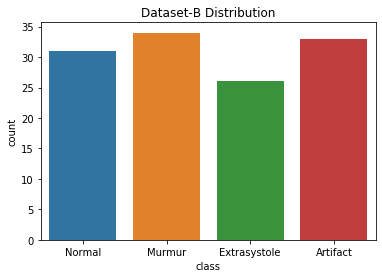

In [4]:
plot = sns.countplot(x='class', data=df).set_title('Dataset-B Distribution').get_figure()

### Back to reality

In [5]:
# Only take this select set of features from the Dataset A

X = df.iloc[:,0:17]
X[['maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2']] = df[['maxstdS1', 'maxstdS2','mmstdS1', 'mmstdS2']]

# Normalise the features

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)
x_dim = X.shape[1]

# Give the columns back their names....

X.columns = [ 'stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 
          'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,
          'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT',
         'maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2']
X.head()

,stdPCA1,stdPCA2,stdPCA3,meanPCA1,meanPCA2,meanPCA3,meanS1,meanS2,stdS1,stdS2,...,ratios,stdFFTSHA,lenFFTSHA,stdlenFFTSHA,lenstdFFTSHA,posFFT,maxstdS1,maxstdS2,mmstdS1,mmstdS2
0,0.319128,0.725107,0.834288,0.525408,0.563569,0.483254,0.136398,0.030223,0.013630,0.008166,...,0.471032,0.149668,0.200000,0.099185,0.011421,0.416667,0.016788,0.007698,0.013665,0.005471
1,0.930489,0.080488,0.288644,0.511140,0.508514,0.600222,0.693966,0.126579,0.129271,0.075983,...,0.553571,0.175355,0.222222,0.101356,0.010620,0.375000,0.182591,0.002681,0.182591,0.075983
2,0.472147,0.603098,0.622030,0.512529,0.551461,0.517707,0.493878,0.079558,0.223347,0.018768,...,0.531235,0.096125,0.333333,0.080668,0.032069,0.125000,0.044522,0.004889,0.315471,0.005361
3,0.562043,0.527292,0.545267,0.592769,0.519388,0.479424,0.087394,0.024925,0.020998,0.003613,...,0.720608,0.111594,0.233333,0.087953,0.018741,0.250000,0.027298,0.003103,0.025034,0.002849
4,0.272438,0.713853,0.892318,0.574308,0.571406,0.468348,0.125525,0.039336,0.023045,0.003680,...,0.339286,0.562892,0.033333,0.784206,0.000460,0.500000,0.032692,0.003066,0.026770,0.002962


In [6]:
# For testing later on ...

P = X.iloc[33:40,:]

In [9]:
# Get the classes

Y = df.iloc[:,toremove-1:toremove]
print(Y['class'].unique())

['Normal' 'Murmur' 'ExtraHS' 'Artifact']


In [8]:
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
Y = encoder.transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Split data

In [9]:
X,Y = shuffle(X,Y,random_state=13)

In [10]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20, random_state = 19)


In [11]:
train_outcome = pd.crosstab(index = Y_train, columns = "count")
test_outcome = pd.crosstab(index = Y_test, columns = "count")

print(train_outcome,'\n\n',test_outcome)

col_0  count
row_0       
0         31
1         20
2         26
3         22 

 col_0  count
row_0       
0          2
1          6
2          8
3          9


## The Model

In [12]:
model = XGBClassifier(objective='multi:softmax')

In [13]:
# param_test1 = {
#  'max_depth':range(3,10,2),
#  'min_child_weight':range(1,6,2)
# }
# gsearch1 = GridSearchCV(model, 
#  param_grid = param_test1,n_jobs=4,iid=False, cv=5)

# gsearch1.fit(X_train,Y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [14]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth":range(3,10,2), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4),
    'min_child_weight':range(1,6,2)
}

search = RandomizedSearchCV(model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=4,return_train_score=True)

search.fit(X, Y)

search.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  49 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 349 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 593 out of 600 | elapsed:   17.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   17.8s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'colsample_bytree': 0.8265287979191537,
 'gamma': 0.3976709189795487,
 'learning_rate': 0.2535193644360661,
 'max_depth': 9,
 'min_child_weight': 5,
 'n_estimators': 134,
 'subsample': 0.7276401892973022}

In [35]:
model = XGBClassifier(objective='multi:softmax', colsample_bytree=0.7299924747454009,gamma=0.22962444598293358,learning_rate=0.13011258334170656,max_depth=9,min_child_weight= 5, n_estimators=121, subsample =  0.6225646316108401)

In [36]:
eval_set = [(X_train, Y_train), (X_test, Y_test)]

In [17]:
#Y_train.shape
#eval_metric=["merror", "mlogloss"],,eval_metric="auc" objective='multi:softmax',

In [37]:
model.fit(X_train, Y_train , early_stopping_rounds=5, eval_metric=["merror", "mlogloss"], eval_set=eval_set)#, verbose=True)

[0]	validation_0-merror:0.252525	validation_0-mlogloss:1.21496	validation_1-merror:0.52	validation_1-mlogloss:1.27375
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-merror:0.232323	validation_0-mlogloss:1.10791	validation_1-merror:0.4	validation_1-mlogloss:1.20288
[2]	validation_0-merror:0.232323	validation_0-mlogloss:1.01791	validation_1-merror:0.44	validation_1-mlogloss:1.1501
[3]	validation_0-merror:0.232323	validation_0-mlogloss:0.944771	validation_1-merror:0.4	validation_1-mlogloss:1.08478
[4]	validation_0-merror:0.191919	validation_0-mlogloss:0.877887	validation_1-merror:0.44	validation_1-mlogloss:1.0573
[5]	validation_0-merror:0.191919	validation_0-mlogloss:0.799963	validation_1-merror:0.44	validation_1-mlogloss:1.01149
[6]	validation_0-merror:0.171717	validation_0-mlogloss:0.75319	validation_1-merror:0.44	validation_1-mlogloss:0.960716
[7]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8265287979191537,
              gamma=0.3976709189795487, learning_rate=0.2535193644360661,
              max_delta_step=0, max_depth=9, min_child_weight=5, missing=None,
              n_estimators=134, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7276401892973022, verbosity=1)

# K Fold?

In [38]:
kfold = StratifiedKFold(n_splits=5, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(results)

Accuracy: 61.36% (2.73%)
[0.59259259 0.6        0.64       0.58333333 0.65217391]


In [39]:
## predictions

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]


In [40]:
accuracy = accuracy_score(Y_test, predictions)

In [41]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.00%


In [42]:
CM = confusion_matrix(Y_test, y_pred)
print(CM)

[[2 0 0 0]
 [3 3 0 0]
 [0 0 6 2]
 [0 3 2 4]]


In [43]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       0.50      0.50      0.50         6
           2       0.75      0.75      0.75         8
           3       0.67      0.44      0.53         9

    accuracy                           0.60        25
   macro avg       0.58      0.67      0.59        25
weighted avg       0.63      0.60      0.60        25



In [44]:
results = model.evals_result()

In [26]:
ephocs = len(results['validation_0']['merror'])

In [27]:
x_axis = range(0, ephocs)

In [28]:
with open('./Models/A_XGB_stats.txt', 'a+') as f:
           f.write('\n=================Saved 13---19 =============================================\n' + filename  +'\n\n' + str(CM) +'\n\n' + 'Dimensions: ' + str(x_dim) + '\n'+ 'Testing Accuracy: ' + str(000) + ' Training Acc: ' + str(000) + '\nTesting Score: '+ str(accuracy) + '\n\n' + classification_report(Y_test,y_pred))

### Plots

Text(0.5, 1.0, 'Log loss')

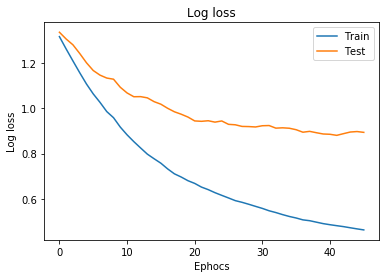

In [29]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label = 'Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label = 'Test')
ax.legend()
plt.ylabel('Log loss')
plt.xlabel('Ephocs')
plt.title('Log loss')
# model_name_ = './Models/XGB_Dataset_A_68_E57_v4'
# plt.savefig(model_name_ + '_lL_'+ '.jpg')
# plt.savefig(model_name_ + '_lL_'+ '.png')


Text(0.5, 1.0, 'Classification loss')

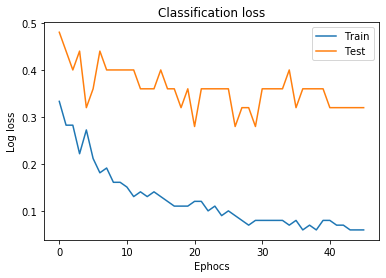

In [30]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label = 'Train')
ax.plot(x_axis, results['validation_1']['merror'], label = 'Test')
ax.legend()
plt.ylabel('Log loss')
plt.xlabel('Ephocs')
plt.title('Classification loss')
# plt.savefig(model_name_ + '_CL_'+ '.jpg')
# plt.savefig(model_name_ + '_CL_'+ '.png')
# plt.show()

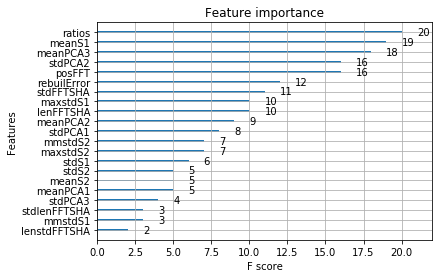

In [45]:
a = xgb.plot_importance(model)
# a.figure.savefig(model_name_ + '.jpg')
# a.figure.savefig(model_name_ + '.png')

In [32]:
import pickle

In [33]:
# Saving the Model

# model_ = open(model_name_ + '.pkl', "wb")
# pickle.dump(model,model_)
# model_pkl = open(model_name_ + '.pkl', "rb")
# model_test = pickle.load(model_pkl)

In [34]:
model_test.predict(P)

NameError: name 'model_test' is not defined

In [ ]:
importances = model.feature_importances_

importances_ = importances.tolist()
labels = ['stdPCA1', 'stdPCA2', 'stdPCA3', 'meanPCA1', 
               'meanPCA2', 'meanPCA3', 'meanS1', 'meanS2', 
          'stdS1', 'stdS2','rebuilError', 'ratios','stdFFTSHA' ,
          'lenFFTSHA', 'stdlenFFTSHA' ,'lenstdFFTSHA' ,'posFFT',
         'maxstdS1', 'maxstdS2', 'mmstdS1', 'mmstdS2',
         'posRatio','stdWavelet','meanWavelet']

labels= pd.DataFrame(labels)
importances_ = pd.DataFrame(importances_)

FEAT_IMPORT = pd.concat([labels, importances_], axis = 1)

FEAT_IMPORT.columns = ['Features', 'Importances']
FEAT_IMPORT.sort_values(by=['Importances'], ascending = False)

In [ ]:
b = np.sort(model.feature_importances_)
plt.barh(range(len(FEAT_IMPORT)), np.sort(FEAT_IMPORT["Importances"]))
plt.ylabel('Features')
plt.xlabel('Importances')
plt.title("Feature Importances")
plt.show()